# Feature detection and matching
1. Harris Corner Detector
2. Histogram of Oriented Gradients
3. Canny Operator
4. Hough Transform

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## 1. Harris Corner Detector

In [2]:
def find_harris_corners(input_img, k=0.04, window_size = 5, threshold = 1000):
    '''
    input_img: the image that we look for conners
    k: constant, deault 0.04
    window_size: size of window that we consider to look for conners, default 5x5
    threshold: to decide whether a pixel is a conner, default 0.01
    '''


    corners = []
    output_img = np.copy(input_img)
    if(len(output_img.shape) == 3): processed_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)
    print("output_img shape = ", output_img.shape)

    offset = int(window_size/2)
    y_range = processed_img.shape[0] - offset
    x_range = processed_img.shape[1] - offset

    # Any kernel (Sobel, ...) can be used to calculate gradient of input image
    dy, dx = np.gradient(processed_img)
    # print(dy)

    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2


    # your implementation here .....
    

    return corners, output_img

In [3]:
img = cv2.imread('chess.png') # , cv2.IMREAD_GRAYSCALE, chess.png
assert img is not None, "file could not be read, check with os.path.exists()"
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
print("img shape = ", img.shape)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img shape =  (449, 640, 3)


output_img shape =  (449, 640, 3)


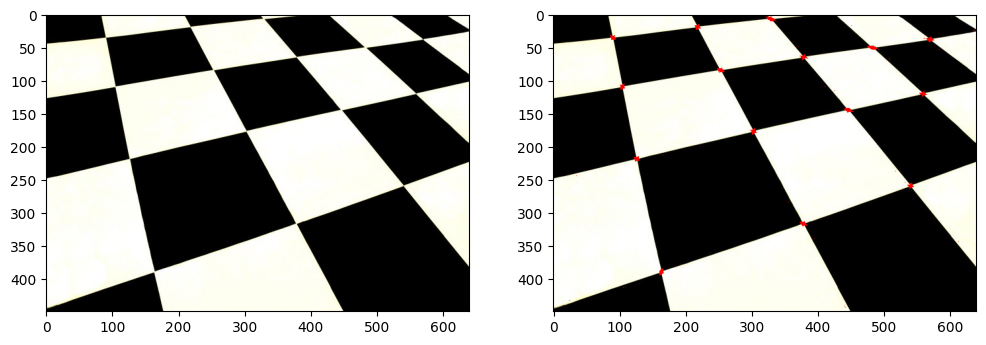

In [5]:
connerList, outputImg = find_harris_corners(img, k=0.06, window_size = 5, threshold = 40000.00)
# threshold: empirically selected
f, axis_array = plt.subplots(1,2, figsize=(12,8))
axis_array[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axis_array[1].imshow(cv2.cvtColor(outputImg, cv2.COLOR_BGR2RGB))

## 2. Histogram of Oriented Gradients

In [3]:
img = cv2.imread('popularImage.png') # , cv2.IMREAD_GRAYSCALE, chess.png
assert img is not None, "file could not be read, check with os.path.exists()"
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[3:307, 3:307]
print(img_gray.shape)

(304, 304)


In [4]:
'''
Compute gradient of an image by rows and columns
'''
dx, dy = np.gradient(img_gray)
magnitude_gradient = np.sqrt(dy**2 + dx**2)
orientation_gradient = abs(np.rad2deg(np.arctan2(dy,dx))) # *180 / np.pi
# print(orientation_gradient)

In [5]:
bins = np.arange(0, 180, 20)
print(bins)

[  0  20  40  60  80 100 120 140 160]


In [6]:
def hog_cell(cell_mag, cell_dir, bins = [0, 20, 40, 60, 80, 100, 120, 140, 160]):
    '''
    magnitude of each orientation is distibuted to bins using interpolation algorithm
    '''
    cell_hist = np.zeros(len(bins))
    last_bin_idx = len(bins) - 1
    mags = cell_mag.flatten()
    dirs = cell_dir.flatten()
    # print(mags)
    # print(dirs)
    for i in range(len(dirs)):
        for b in range(len(bins)):
            # print(b)
            if(dirs[i] > bins[b] and b == len(bins)-1):
                cell_hist[8] += mags[i] - (dirs[i]-bins[last_bin_idx])/(180 - bins[last_bin_idx])*mags[i]
                cell_hist[0] += (dirs[i]-bins[last_bin_idx])/(180 - bins[last_bin_idx])*mags[i]
                # print("over 140", cell_hist)
            else:
                # print(Bins[b+1])
                if(dirs[i]>bins[b] and dirs[i]<=bins[b+1]):
                    cell_hist[b] += (bins[b+1]-dirs[i])/(bins[b+1] - bins[b])*mags[i]
                    cell_hist[b+1] += (dirs[i]-bins[b])/(bins[b+1] - bins[b])*mags[i]

    # print(cell_hist)
    return cell_hist



In [7]:
# for testing
cell_mag = np.array([[1, 2], [3, 4]])
cell_dir = np.array([[-125, 85], [150, 4]])
# print(cell)
cell_hist = hog_cell(cell_mag, cell_dir)
print(cell_hist, type(cell_hist))

[3.2 0.8 0.  0.  1.5 0.5 0.  1.5 1.5] <class 'numpy.ndarray'>


In [8]:
def hist_of_oriented_grandient(img_gray, window_size = 16, cell_size = 4):
    '''
    In this example, window size (patch size) and cell size are given as default
    If lecturer want to change these value, remember to resize image to suitable size
    '''
    dy, dx = np.gradient(img_gray)
    # print(dy.shape)
    magnitude_gradient = np.sqrt(dy**2 + dx**2)
    # print(magnitude_gradient.shape)
    orientation_gradient = abs(np.rad2deg(np.arctan2(dy,dx))) # *180 / np.pi
    yRange = img_gray.shape[0] // window_size
    xRange = img_gray.shape[1] // window_size
    # print("yRange, xRange = ", yRange, xRange)

    img_hist = np.array([])
    for y in range(yRange):
        for x in range(xRange):
            window = img_gray[(y*window_size):((y+1)*window_size), (x*window_size):((x+1)*window_size)]
            window_magnitude_gradient = magnitude_gradient[(y*window_size):((y+1)*window_size), (x*window_size):((x+1)*window_size)]
            window_orientation_gradient = orientation_gradient[(y*window_size):((y+1)*window_size), (x*window_size):((x+1)*window_size)]
            # if(y==yRange-1 and x==xRange-1): print(window_orientation_gradient.shape)
            window_hist = np.array([])
            iRange = int(np.sqrt(window_size/cell_size))
            for i in range(iRange):
                for j in range(iRange):
                    # if(y==0 and x==0): print("i, j = ", i, j)
                    cell_mag = window_magnitude_gradient[(i*cell_size):((i+1)*cell_size), (j*cell_size):((j+1)*cell_size)]
                    cell_dir = window_orientation_gradient[(i*cell_size):((i+1)*cell_size), (j*cell_size):((j+1)*cell_size)]
                    cell_hist = hog_cell(cell_mag, cell_dir)
                    # if(y==0 and x==0): print("cell_hist.shape = ", cell_hist.shape)
                    window_hist = np.hstack((window_hist,cell_hist))
                    # print(window_hist)
                    # if(y==0 and x==0): print("cell_hist shape, window_hist.shape = ", cell_hist.shape, window_hist.shape)
            img_hist = np.hstack((img_hist,window_hist))

    return img_hist.reshape(yRange*xRange, 36)

In [9]:
hog_fratures = hist_of_oriented_grandient(img_gray)
# print(hog_fratures)
print("hog_fratures = ", hog_fratures.shape)


hog_fratures =  (361, 36)


(array([1.2259e+04, 4.4100e+02, 1.6500e+02, 8.5000e+01, 1.9000e+01,
        9.0000e+00, 9.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+00]),
 array([  0.        ,  78.537375  , 157.07475   , 235.612125  ,
        314.1495    , 392.68687501, 471.22425001, 549.76162501,
        628.29900001, 706.83637501, 785.37375001]),
 <BarContainer object of 10 artists>)

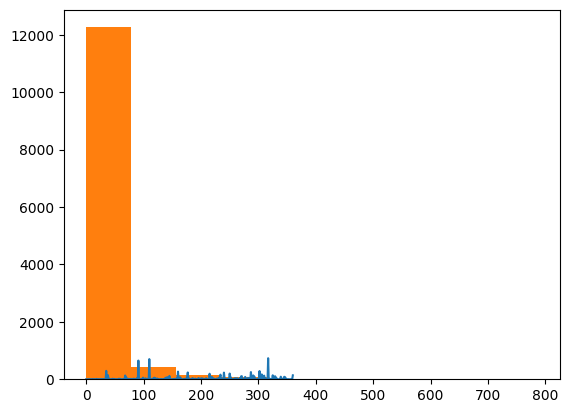

In [10]:
plt.plot(hog_fratures[:,35])
plt.hist(hog_fratures.flatten())

## Canny operator

In [58]:


# defining the canny detector function

# here weak_th and strong_th are thresholds for
# double thresholding step
def Canny_detector(img_gray, weak_th = None, strong_th = None):
    '''
    input is an image in grayscale
    '''
    # Noise reduction step
    img = cv2.GaussianBlur(img_gray, (5, 5), 1.4)

    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)

    # Conversion of Cartesian coordinates to polar
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # setting the minimum and maximum thresholds
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5

    # getting the dimensions of the input image
    height, width = img.shape

    # Looping through every pixel of the grayscale
    # image
    for i_x in range(width):
        for i_y in range(height):

            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)

            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1

            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue

            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0

    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)
    ids = np.zeros_like(img)

    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):

            grad_mag = mag[i_y, i_x]

            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2


    # finally returning the magnitude of
    # gradients of edges
    return mag.astype('uint8')

In [67]:
canny_img = Canny_detector(img_gray, 50, 150)

In [68]:
edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

In [69]:
print(canny_img.shape)
print(edges.shape)

(304, 304)
(304, 304)


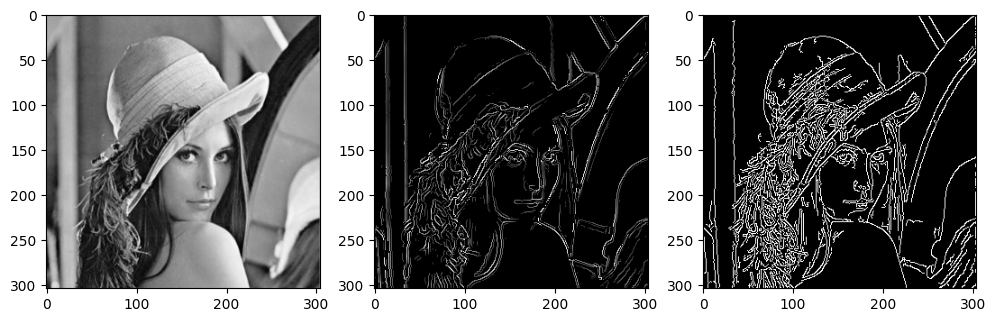

In [70]:
f, axis_array = plt.subplots(1,3, figsize=(12,4))
axis_array[0].imshow(cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB))
axis_array[1].imshow(cv2.cvtColor(canny_img, cv2.COLOR_GRAY2RGB))
axis_array[2].imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))

## Hough transform

In [144]:
def houghLine(image):
  #Get image dimensions
  # y for rows and x for columns
  Ny = image.shape[0]
  Nx = image.shape[1]

  #Max diatance is diagonal one
  Maxdist = int(np.round(np.sqrt(Nx**2 + Ny ** 2)))

  # Theta in range from -90 to 90 degrees
  thetas = np.deg2rad(np.arange(-90, 90))
  #Range of radius
  rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
  accumulator = np.zeros((2 * Maxdist, len(thetas)))

  for y in range(Ny):
    for x in range(Nx):
      # Check if it is an edge pixel
      #  NB: y -> rows , x -> columns
      if image[y,x] > 0:
        # Map edge pixel to hough space
        for k in range(len(thetas)):
          # Calculate space parameter
          r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])
          # Update the accumulator
          # N.B: r has value -max to max
          # map r to its idx 0 : 2*max
          accumulator[int(r) + Maxdist,k] += 1
  return accumulator, thetas, rs

In [145]:
image = np.zeros((150,150))
image[75, 75] = 1
image[50, 50] = 1

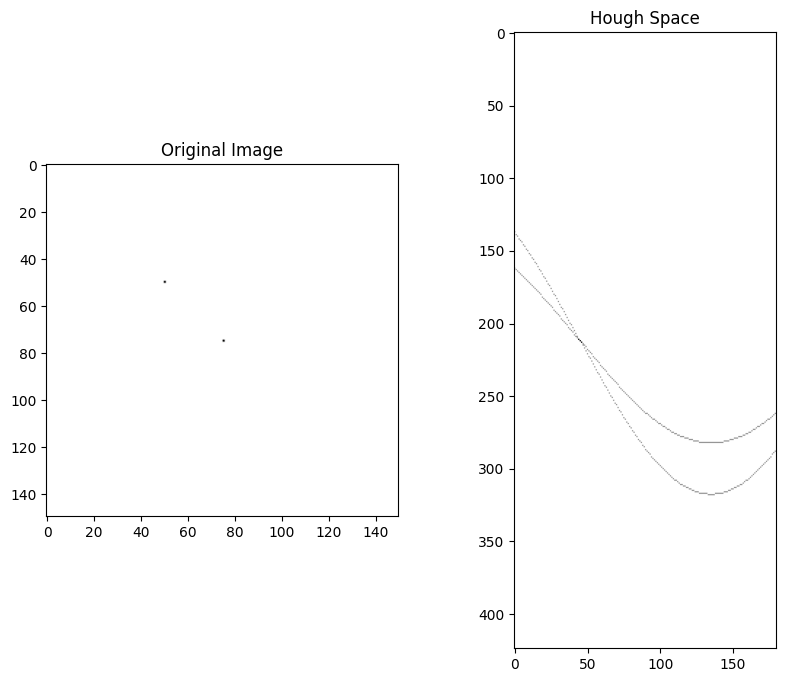

In [146]:
accumulator, thetas, rhos = houghLine(image)
f, axarr = plt.subplots(1,2, figsize = (10, 8))
axarr[0].title.set_text('Original Image')
axarr[0].imshow(image, cmap = 'Greys')
# plt.set_cmap('gray')
axarr[1].title.set_text('Hough Space')
axarr[1].imshow(accumulator, cmap = 'Greys')
# plt.set_cmap('gray')
# plt.show()